# Analysing vote flow transfers with Multivariate LSQ Minimization

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
df15=pd.read_csv('hocl-ge2015-results-full.csv')
df17=pd.read_csv('HoC-GE2017-constituency-results.csv')

# EU file
path = 'C:/Apps/Anaconda3/Python_workGH/'
dfEU = pd.read_csv(path + 'Revised estimates of leave vote in Westminster constituencies - demog_based_estimates.csv')
dfEU = dfEU[['Constituency','Figure to use']].sort_values('Figure to use').reset_index(drop=True)
dfEU.columns = ['constituency_name', 'leave']
nsplitsEU = 3
dfEU['type'] = [np.floor(nsplitsEU*i/len(dfEU)).astype(int) for i in range(len(dfEU))]
dfEU.head()
replacements = {'Ynys Môn':'Ynys Mon', 'Stoke-on-Trent Central':'Stoke-On-Trent Central', 
 'Cities of London and Westminster':'Cities Of London and Westminster',
 'Newcastle upon Tyne Central':'Newcastle Upon Tyne Central', 'Na h-Eileanan an Iar':'Na h-Eileanan An Iar',
 'Newcastle upon Tyne East':'Newcastle Upon Tyne East', 'Newcastle-under-Lyme':'Newcastle-Under-Lyme', 
 'Berwick-upon-Tweed':'Berwick-Upon-Tweed', 'Vale of Glamorgan':'Vale Of Glamorgan', 
 'Stoke-on-Trent North':'Stoke-On-Trent North', 'Forest of Dean':'Forest Of Dean', 
 'Ashton-under-Lyne':'Ashton-Under-Lyne', 'Vale of Clwyd':'Vale Of Clwyd', 
 'City of Durham':'City Of Durham', 'Isle of Wight':'Isle Of Wight',
 'Newcastle upon Tyne North':'Newcastle Upon Tyne North', 
 'Stoke-on-Trent South':'Stoke-On-Trent South', 'Stratford-on-Avon':'Stratford-On-Avon', 'City of Chester':'City Of Chester'}
for const in dfEU.constituency_name:
    if const in replacements.keys():
        dfEU.constituency_name.replace(to_replace=const, value=replacements[const], inplace=True)

print([df15.shape, df17.shape, dfEU.shape])


[(3971, 17), (650, 29), (632, 3)]


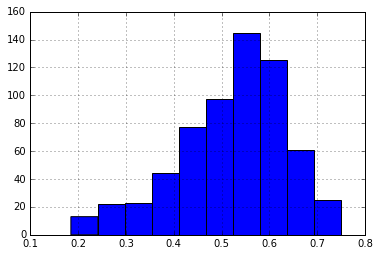

In [2]:
dfEU.leave.hist()

In [3]:
# Select relevant columns put party results as columns, 
# put constituency as row indices 
df15b = pd.pivot_table(
    df15[['constituency_name','party_abbreviation','votes']],
    index='constituency_name', columns='party_abbreviation', values='votes'
)[ ['Con','Lab','LD','UKIP','Green','PC','SNP'] ].replace(np.nan,0)

df15b.columns = ['con','lab','ld','ukip','green','snp','pc']
df15b = df15b.reset_index()
totVotes = df15[['constituency_name','votes']].groupby(['constituency_name']).agg({'votes':{'totalVotes':sum}})['votes'].reset_index()

# Take region_name from 2017 file
df15b = df15b.merge(df17[['region_name','constituency_name']],
                    how='left',on='constituency_name').merge(totVotes,how='left',on='constituency_name')
df15b = df15b.sort_values('constituency_name')
df15b = df15b.reset_index(drop=True)
df15b['others'] = df15b['totalVotes'] - df15b[['con', 'lab', 'ld', 'ukip', 'green','snp','pc']].sum(axis=1)
df15b.head()
print(len(df15b))
# Add EU
df15b = df15b.merge(dfEU, how='left',on='constituency_name')
#df15b[df15b.leave.isnull()]

650


In [4]:
df17b = df17[['con', 'lab', 'ld', 'ukip', 'green','snp','pc','constituency_name','region_name']]
df17b['totalVotes'] = df17['valid_votes']
df17b['others'] = df17b['totalVotes']-df17b[['con', 'lab', 'ld', 'ukip', 'green','snp','pc']].sum(axis=1)
df17b = df17b.sort_values('constituency_name')
df17b = df17b.reset_index(drop=True)
# Add EU
df17b = df17b.merge(dfEU, how='left',on='constituency_name')
df17b.head()

,con,lab,ld,ukip,green,snp,pc,constituency_name,region_name,totalVotes,others,leave,type
0,5901,22662,599,1345,0,0,2761,Aberavon,Wales,33268,0,0.599655,2.0
1,14337,13702,941,0,0,0,3170,Aberconwy,Wales,32150,0,0.533838,1.0
2,8341,11031,1693,0,0,15170,0,Aberdeen North,Scotland,36757,522,0.430998,0.0
3,18746,9143,2610,0,0,13994,0,Aberdeen South,Scotland,44493,0,0.323257,0.0
4,8813,14096,802,0,0,14291,0,Airdrie and Shotts,Scotland,38002,0,0.400513,0.0


In [5]:
X15 = df15b[~df15b.region_name.isin(['Wales','Scotland','Northern Ireland']) ][['con', 'lab', 'ld', 'ukip', 'green','others']]
print(len(X15))
X17 = df17b[~df17b.region_name.isin(['Wales','Scotland','Northern Ireland']) ][['con', 'lab', 'ld', 'ukip', 'green','others']]
print(len(X17))

533
533


In [6]:
Parties=['con', 'lab', 'ld', 'ukip', 'green','others']
Colors=['blue','red','yellow','purple','green','black']

In [7]:
remainers = list(df15b[~df15b.region_name.isin(['Wales','Scotland','Northern Ireland']) ].type==0)
undecideds = list(df15b[~df15b.region_name.isin(['Wales','Scotland','Northern Ireland']) ].type==1)
leavers = list(df15b[~df15b.region_name.isin(['Wales','Scotland','Northern Ireland']) ].type==2)

In [8]:
Xx[outliers_indices]

NameError: name 'Xx' is not defined

## Constrained Multivariate LSQ Minimization for Voter Flow Matrices

In [94]:
def res_squares_2d(x, X, Y, xshape, Yshape):
    """ Sum of squared residuals """
    Y = np.reshape(Y,Yshape) 
    x = np.reshape(x,xshape)
    return sum(sum((np.dot(np.array(X), x)-Y)**2))

In [259]:
from scipy.optimize import minimize
#seats = [np.argmax(np.array(X15),axis=1)==0]
seats = [True for i in range(X15.shape[0])]
#seats = outliers
seats = remainers
Xx = np.c_[np.array(X15[seats]), np.ones(X15[seats].shape[0])]
Yy = np.array(X17[seats])
#Xx = Xx[[i for i in range(Yy.shape[0]) if i not in outliers_indices ]]
#Yy = Yy[[i for i in range(Yy.shape[0]) if i not in outliers_indices ]]
Norm = max([Xx.max(),Yy.max()])
Xnorm = Xx/Norm
Ynorm = Yy/Norm
W0norm = np.random.random( (len(Xnorm[1]), len(Ynorm[1])) )
print(Xx.shape,Yy.shape)
print(Xnorm.shape,Ynorm.shape)
print(W0norm.shape)

(61, 7) (61, 6)
(61, 7) (61, 6)
(7, 6)


In [260]:
bnds = tuple([     (0,None) for i in range(W0norm.size)
])
cons1 = tuple([    {'type': 'eq','fun' : lambda x: np.array(sum(x[0:(7-1)*6:6])-1)},
                   {'type': 'eq','fun' : lambda x: np.array(sum(x[1:(7-1)*6:6])-1)},
                   {'type': 'eq','fun' : lambda x: np.array(sum(x[2:(7-1)*6:6])-1)},
                   {'type': 'eq','fun' : lambda x: np.array(sum(x[3:(7-1)*6:6])-1)},
                   {'type': 'eq','fun' : lambda x: np.array(sum(x[4:(7-1)*6:6])-1)},
                   {'type': 'eq','fun' : lambda x: np.array(sum(x[5:(7-1)*6:6])-1)} 
])
cons2 = tuple([    {'type': 'eq','fun' : lambda x: np.array(sum(x[0*6:(0+1)*6])-1)},
                   {'type': 'eq','fun' : lambda x: np.array(sum(x[1*6:(1+1)*6])-1)},
                   {'type': 'eq','fun' : lambda x: np.array(sum(x[2*6:(2+1)*6])-1)},
                   {'type': 'eq','fun' : lambda x: np.array(sum(x[3*6:(3+1)*6])-1)},
                   {'type': 'eq','fun' : lambda x: np.array(sum(x[4*6:(4+1)*6])-1)},
                   {'type': 'eq','fun' : lambda x: np.array(sum(x[5*6:(5+1)*6])-1)} 
])
cons3 = tuple([    {'type': 'ineq','fun' : lambda x: np.array(1-sum(x[0*6:(0+1)*6]))},
                   {'type': 'ineq','fun' : lambda x: np.array(1-sum(x[1*6:(1+1)*6]))},
                   {'type': 'ineq','fun' : lambda x: np.array(1-sum(x[2*6:(2+1)*6]))},
                   {'type': 'ineq','fun' : lambda x: np.array(1-sum(x[3*6:(3+1)*6]))},
                   {'type': 'ineq','fun' : lambda x: np.array(1-sum(x[4*6:(4+1)*6]))},
                   {'type': 'ineq','fun' : lambda x: np.array(1-sum(x[5*6:(5+1)*6]))} 
])
cons = cons3
res = minimize(res_squares_2d, W0norm, args=(Xnorm,Ynorm,W0norm.shape,Ynorm.shape), method='SLSQP',
               options={'disp': True}, bounds=bnds, constraints=cons)

Wbnd = np.reshape(res.x,W0norm.shape)
print(np.around(Wbnd,decimals=2))
if cons == cons1:
    print(sum(Wbnd[0:-1]))
if cons == cons2 or cons == cons3:
    print(sum(np.around(Wbnd,decimals=2).T))
print(0<=Wbnd)

Ypreds = Norm*np.dot(np.array(Xnorm), Wbnd)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.18218291881232304
            Iterations: 20
            Function evaluations: 883
            Gradient evaluations: 20
[[ 0.97  0.    0.01  0.    0.02  0.  ]
 [ 0.    1.    0.    0.    0.    0.  ]
 [ 0.09  0.    0.91  0.    0.    0.  ]
 [ 0.31  0.69  0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.  ]
 [ 0.37  0.64  0.94  0.67  0.46  0.12]]
[ 1.   1.   1.   1.   1.   1.   3.2]
[[ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]]


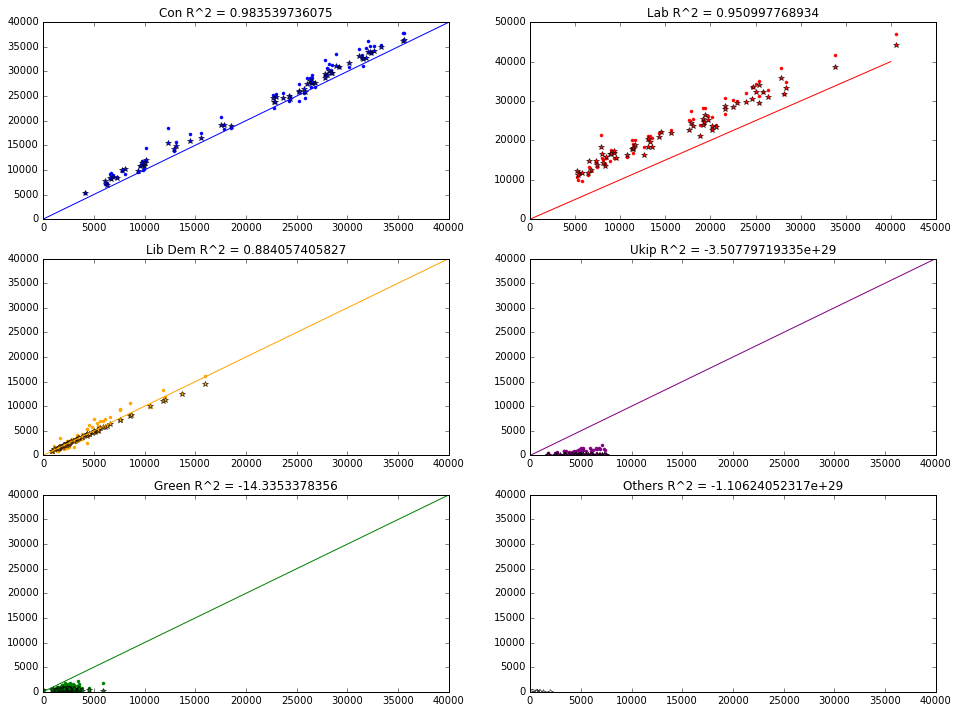

In [261]:
from sklearn.metrics import r2_score

plt.figure(figsize=(16,12))
plt.subplot(3,2,1)
plt.plot(Xx[:,0], Yy[:,0],'.',c='blue')
plt.plot(Xx[:,0], Ypreds[:,0],'*',c='blue')
plt.plot([0,40000],[0,40000])
plt.title('Con R^2 = %s'%r2_score(Ypreds[:,0],Yy[:,0]))
plt.subplot(3,2,2)
plt.plot(Xx[:,1], Yy[:,1],'.',c='red')
plt.plot(Xx[:,1], Ypreds[:,1],'*',c='red')
plt.plot([0,40000],[0,40000],c='red')
plt.title('Lab R^2 = %s'%r2_score(Ypreds[:,1],Yy[:,1]))
plt.subplot(3,2,3)
plt.plot(Xx[:,2], Yy[:,2],'.',c='orange')
plt.plot(Xx[:,2], Ypreds[:,2],'*',c='orange')
plt.plot([0,40000],[0,40000],c='orange')
plt.title('Lib Dem R^2 = %s'%r2_score(Ypreds[:,2],Yy[:,2]))
plt.subplot(3,2,4)
plt.plot(Xx[:,3], Yy[:,3],'.',c='purple')
plt.plot(Xx[:,3], Ypreds[:,3],'*',c='purple')
plt.plot([0,40000],[0,40000],c='purple')
plt.title('Ukip R^2 = %s'%r2_score(Ypreds[:,3],Yy[:,3]))
plt.subplot(3,2,5)
plt.plot(Xx[:,4], Yy[:,4],'.',c='green')
plt.plot(Xx[:,4], Ypreds[:,4],'*',c='green')
plt.plot([0,40000],[0,40000],c='green')
plt.title('Green R^2 = %s'%r2_score(Ypreds[:,4],Yy[:,4]))
plt.subplot(3,2,6)
plt.plot(Xx[:,5], Yy[:,5],'.',c='white')
plt.plot(Xx[:,5], Ypreds[:,5],'*',c='white')
plt.plot([0,40000],[0,40000],c='white')
plt.title('Others R^2 = %s'%r2_score(Ypreds[:,5],Yy[:,5]))

In [262]:
winner15 = np.argmax(np.array(Xx),axis=1)
winner17 = np.argmax(np.array(Yy),axis=1)
winner17Pred = np.argmax(Ypreds,axis=1)

seatChanges=[winner15[ii]!=winner17[ii] for ii in range(len(Xx))]
seatErrsSame=sum(seatChanges)
seatErrsPred=sum([winner17[ii]!=winner17Pred[ii] for ii in range(len(Xx))])
print(['Errors for unchanged: '+str(seatErrsSame)+' ('+str(seatErrsSame/len(Xx))+')',
       'Errors for pred: '+str(seatErrsPred)+' ('+str(seatErrsPred/len(Xx))+')'])

['Errors for unchanged: 5 (0.0819672131148)', 'Errors for pred: 2 (0.0327868852459)']


#### Outliers

In [263]:
outlier_threshold = 0.05
outliers_indices = np.argsort(sum(((Ypreds - Yy)**2).T))[-np.floor(outlier_threshold*Yy.shape[0]).astype(int):]
outliers = [i not in outliers_indices for i in range(Yy.shape[0])]
len(outliers_indices)

3

## Vote shares main parties

In [9]:
dfR15=df15b[(~df15b.region_name.isin(['Scotland','Wales','Northern Ireland']))&(df15b.constituency_name!='Buckingham')
      ][['con', 'lab', 'ld', 'ukip', 'green']]
dfR15["total5party"] = dfR15.sum(axis=1)
dfR15 = dfR15.loc[:,'con':'green'].div(dfR15["total5party"], axis=0)*100
dfR15=dfR15.reset_index(drop=True)
dfR15.head()

,con,lab,ld,ukip,green
0,50.592107,18.332576,8.824230,17.867117,4.383971
1,52.310433,22.480916,3.384224,19.722646,2.101781
2,52.994042,26.686066,8.383317,8.011165,3.925411
3,43.979264,34.781372,2.974823,15.886869,2.377671
4,60.787577,11.197479,7.192308,14.437736,6.384900


In [10]:
dfR17=df17b[(~df17b.region_name.isin(['Scotland','Wales','Northern Ireland']))&(df17b.constituency_name!='Buckingham')
      ][['con', 'lab', 'ld', 'ukip', 'green']]
dfR17["total5party"] = dfR17.sum(axis=1)
dfR17 = dfR17.loc[:,'con':'green'].div(dfR17["total5party"], axis=0)*100
dfR17=dfR17.reset_index(drop=True)
dfR17.head()

,con,lab,ld,ukip,green
0,55.056180,31.617978,7.430031,3.669050,2.226762
1,66.339803,30.274767,3.385430,0.000000,0.000000
2,51.309748,39.067650,7.717513,0.000000,1.905088
3,57.235970,38.897481,2.430402,0.000000,1.436147
4,62.355616,22.719729,7.937799,2.768189,4.218667


In [11]:
[dfR17.shape,dfR15.shape]

[(532, 5), (532, 5)]

## PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
Ncomps=2
pca = PCA(n_components=Ncomps)

data=dfR15.append(dfR17).reset_index(drop=True)
dfPCA=pd.DataFrame(pca.fit_transform(data))
dfRec=pd.DataFrame(pca.inverse_transform(dfPCA))
dfPCA['winner']=data.idxmax(axis=1)

pca_score = pca.explained_variance_ratio_

dfPCA15, dfPCA17 = dfPCA[0:len(dfR15)], dfPCA[len(dfR15):].reset_index(drop=True)

dfPCA.head()

In [ ]:
pca_score

In [ ]:
parties=['con','lab','ld','ukip','green']
colors=['blue','red','yellow','purple','green']

if Ncomps==2:
    plt.figure(figsize=(16, 12), facecolor='w', edgecolor='k')
    plt.subplot(1,2,1)
    for i in range(len(parties)):
        selectSeats=dfPCA17.winner==parties[i]
        plt.subplot(1,2,1)
        plt.title('2015 positions')
        plt.scatter(dfPCA15[selectSeats][0], dfPCA15[selectSeats][1], 
                   c=colors[i])
        plt.axis([-50, 70, -30, 50])
        plt.grid()
        plt.subplot(1,2,2)
        plt.title('2017 positions')
        plt.scatter(dfPCA17[selectSeats][0], dfPCA17[selectSeats][1], 
                   c=colors[i])
        plt.axis([-50, 70, -30, 50])
        plt.grid()    
        
    selectSeats=(~df15b.region_name.isin(['Scotland','Wales','Northern Ireland']))&(
    df15b.constituency_name!='Buckingham')&(df17b.ukip!=0)&(df15b.ukip!=0)
    plt.scatter(dfPCA17[selectSeats][(dfPCA15[selectSeats].winner!=dfPCA17[selectSeats].winner)][0],
            dfPCA17[selectSeats][(dfPCA15[selectSeats].winner!=dfPCA17[selectSeats].winner)][1],c='black')
if Ncomps==3:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure( figsize=(16, 8), facecolor='w', edgecolor='k')
    ax1 = fig.add_subplot(1,2,1, projection='3d')
    ax2 = fig.add_subplot(1,2,2, projection='3d')
    for i in range(len(parties)):
        ax1.scatter(xs=dfPCA15[dfPCA17.winner==parties[i]][0], ys=dfPCA15[dfPCA17.winner==parties[i]][1], 
                   zs=dfPCA15[dfPCA17.winner==parties[i]][1], zdir='z', c=colors[i], depthshade=True)
        ax2.scatter(xs=dfPCA17[dfPCA17.winner==parties[i]][0], ys=dfPCA17[dfPCA17.winner==parties[i]][1], 
                   zs=dfPCA17[dfPCA17.winner==parties[i]][1], zdir='z', c=colors[i], depthshade=True)


    


In [ ]:

#dfPCA17[selectSeats][(dfPCA15[selectSeats].winner!=dfPCA17[selectSeats].winner)]
#(dfPCA15.winner!=dfPCA17.winner)[selectSeats]

In [ ]:
#plt.figure()
if Ncomps==2:

    Changes=dfPCA17[[0,1]]-dfPCA15[[0,1]]
    U, V = Changes[0], Changes[1]
    X, Y = dfPCA17[0], dfPCA17[1]
    #plt.quiver(X, Y, U, V, units='width')

    fig = plt.figure(figsize=(16, 12), facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    for i in range(len(parties)):
        
        if i==0: # seats that changed hands in black
            selectSeats=(~df15b.region_name.isin(['Scotland','Wales','Northern Ireland']))&(
            df15b.constituency_name!='Buckingham')&(df17b.ukip!=0)&(df15b.ukip!=0)
            
            ax.quiver(dfPCA15[selectSeats][(dfPCA15[selectSeats].winner!=dfPCA17[selectSeats].winner)][0],
                dfPCA15[selectSeats][(dfPCA15[selectSeats].winner!=dfPCA17[selectSeats].winner)][1],
                Changes[selectSeats][(dfPCA15[selectSeats].winner!=dfPCA17[selectSeats].winner)][0],
                Changes[selectSeats][(dfPCA15[selectSeats].winner!=dfPCA17[selectSeats].winner)][1],
                color='black',alpha=0.35,scale=1,units='xy')
        
        selectSeats=dfPCA17.winner==parties[i]
        ax.quiver(dfPCA15[selectSeats][0], dfPCA15[selectSeats][1],
                  Changes[selectSeats][0], Changes[selectSeats][1],
                  color=colors[i],alpha=0.25,scale=1,units='xy')
        
        plt.xlim(-40, 65)
        plt.ylim(-20, 45)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.grid()

        
if Ncomps==3:
    
    Changes=dfPCA17[[0,1,2]]-dfPCA15[[0,1,2]]
    fig = plt.figure(figsize=(16, 12), facecolor='w', edgecolor='k')
    #ax = fig.add_subplot(111)
    ax = fig.gca(projection='3d')
    for i in range(len(parties)):
        ax.quiver(dfPCA15[dfPCA17.winner==parties[i]][0], dfPCA15[dfPCA17.winner==parties[i]][1], 
                  dfPCA15[dfPCA17.winner==parties[i]][2],
                  Changes[dfPCA17.winner==parties[i]][0], Changes[dfPCA17.winner==parties[i]][1],
                  Changes[dfPCA17.winner==parties[i]][2],length=20,
                  color=colors[i])
        #plt.xlim(-40, 65)
        #plt.ylim(-20, 45)
        #plt.zlim(-50, 55)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.grid()
    

In [ ]:
#plt.figure()
if Ncomps==2:

    Changes=dfPCA17[[0,1]]-dfPCA15[[0,1]]
    U, V = Changes[0], Changes[1]
    X, Y = dfPCA17[0], dfPCA17[1]
    #plt.quiver(X, Y, U, V, units='width')

    fig = plt.figure(figsize=(16, 12), facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    for i in range(len(parties)):
        selectSeats=dfPCA17.winner==parties[i]
        ax.quiver(0*dfPCA15[selectSeats][0], 0*dfPCA15[selectSeats][1],
                  Changes[selectSeats][0], Changes[selectSeats][1],
                  color=colors[i],alpha=0.25,scale=1,units='xy')
        plt.xlim(-20, 40)
        plt.ylim(-40, 30)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.grid()

In [ ]:
selectSeats=dfPCA17.winner==parties[1]
H=np.angle(Changes[selectSeats][0]+1j*Changes[selectSeats][1])
plt.figure()
plt.hist(H,bins=50)

In [ ]:
# https://stackoverflow.com/questions/32750915/pca-inverse-transform-manually

In [ ]:
pca.components_


In [ ]:
np.dot(np.array(dfR17.iloc[0]) - pca.mean_, pca.components_.T) 

In [ ]:
xx=np.dot(np.array(dfR17-pca.mean_),pca.components_.T) 
xx

In [ ]:
np.array(dfPCA17[[0,1]])

In [ ]:
pca.transform(np.array(dfR17.iloc[0]).reshape(1, -1))

In [ ]:
np.dot(np.array([-14.98041246,  -2.42408367]), pca.components_) + pca.mean_

In [ ]:
pca.mean_

In [ ]:
dfR17.mean()

In [ ]:
np.dot(np.array([1,  0]), pca.components_) + pca.mean_

In [ ]:
np.dot(np.array([0,  1]), pca.components_) + pca.mean_

In [ ]:
pca.transform(np.array([ 44.77697428,  43.0435873 ,   8.29434709,   2.09773841,   1.78735293]))

In [ ]:
np.dot(pca.components_[0],pca.components_[1].T)

In [ ]:
U

In [ ]:
Changes

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(111)
ax.quiver(1,1,1,2,scale=1,units='xy')
plt.xlim(0, 7)
plt.ylim(0, 7)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()



In [ ]:
u = v = np.zeros((11,11))
u[5,5] = 0.2

In [ ]:
u

In [ ]:
np.argmin(Changes[0])

In [ ]:
dfPCA17.iloc[148]

In [ ]:
dfPCA15.iloc[148]

In [ ]:
dfR15.iloc[148]

In [ ]:
dfR17.iloc[148]